In [1]:
# Регрессия (На основе предсказания цены дома)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import boston_housing
from keras import models, layers, losses, metrics, optimizers

In [3]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [4]:
train_data.shape, test_data.shape

((404, 13), (102, 13))

In [6]:
# Нормализация (центрирование со стандартным отклонением 1)
mean = train_data.mean(axis=0)
train_data = train_data - mean
std = train_data.std(axis=0)
train_data = train_data / std

test_data -= mean
test_data /= std

In [7]:
# Функция создания модели
def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer=optimizers.RMSprop(), loss=losses.mse, metrics=[metrics.mae])
  return model

In [16]:
# Перекресная проверка по K-блокам
k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print('Processing fold #', i)
  # для валидации
  val_data = train_data[i*num_val_samples : (i+1)*num_val_samples]
  val_targets = train_targets[i*num_val_samples : (i+1)*num_val_samples]
  # для тренировки
  partial_train_data = np.concatenate([train_data[ : (i)*num_val_samples],
                                       train_data[(i+1)*num_val_samples : ]], axis=0)
  partial_train_target = np.concatenate([train_targets[ : (i)*num_val_samples],
                                       train_targets[(i+1)*num_val_samples : ]], axis=0)
  # модель
  model = build_model()
  history = model.fit(partial_train_data, partial_train_target,
            epochs=num_epochs, batch_size=1, verbose=0, validation_data=(val_data, val_targets))
  mae_history = history.history['val_mean_absolute_error']
  all_mae_histories.append(mae_history)

Processing fold # 0
Processing fold # 1
Processing fold # 2
Processing fold # 3


In [28]:
len(all_mae_histories), len(all_mae_histories[0])

(4, 500)

In [17]:
# История средних оценок проверки по K блокам
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

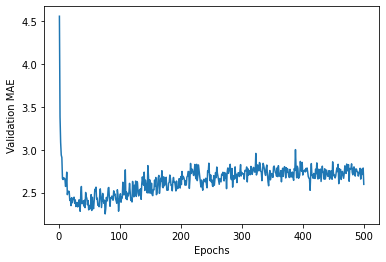

In [19]:
# Оценка MAE по эпохам
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()
# Тут большие значение на первых эпохах -> Попробуем посмотреть график без них
# + сгладим експоненциальным скользящим средним

In [21]:
# функция для сглаживания экспонц. средним значенй
def good_line(points, factor=0.9):
  good_points = []
  for point in points:
    if good_points:
      previous = good_points[-1]
      good_points.append(previous*factor + point*(1-factor))
    else:
      good_points.append(point)  
  return good_points    

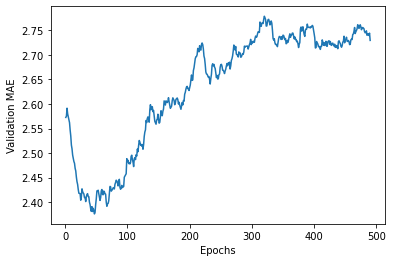

In [22]:
good_mae_history = good_line(average_mae_history[10:])
plt.plot(range(1, len(good_mae_history) + 1), good_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [30]:
# В цикле по k каждый раз получали новую модель и потом все значения между
# показаниями моделей усредняли. Поэтому  поняли что после 80 эпох можно заканчивать

# Обучение окончательной модели
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
test_mse_score, test_mae_score

4/4 [==============================] - 0s 1ms/step - loss: 17.4390 - mean_absolute_error: 2.6669


(17.43903923034668, 2.6669108867645264)

In [33]:
t = model.predict(test_data)
t[0]  # + нужно денормализовать

array([8.447075], dtype=float32)